# lost_and_found data사용해 U-net학습


## 데이터 준비


- 딥러닝 공개 데이터 셋 사용위한 라이브러리 설치

In [ ]:
# !pip install tensorflow-datasets

In [ ]:
# !pip install tfds-nightly

     |████████████████████████████████| 4.1 MB 10.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 공개 데이터셋 임포트
import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Shuffling lost_and_found-train.tfrecord...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Shuffling lost_and_found-test.tfrecord...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = next(iter(ds))

In [ ]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [ ]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [ ]:
# 데이터 백업 만들어줌
raw_x = images
raw_y = labels

In [ ]:
print(raw_x.shape)
print(raw_y.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


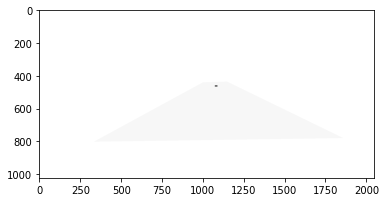

In [ ]:
# 타겟 그림 확인
plt.imshow(raw_y[0].squeeze(), cmap='binary')
plt.show()

확실한 대비를 주기 위해 바꿔줌

In [ ]:
# 색이 들어간 픽셀을 모두 1로 바꿔줌 (회색톤 -> 검정)
labels[labels>1] = 1

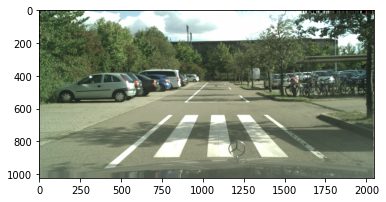

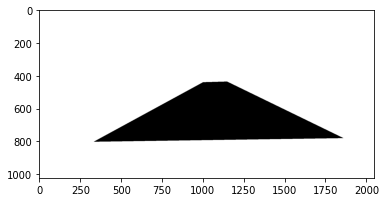

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(raw_x[0])
plt.show()

plt.imshow(raw_y[0].squeeze(), cmap='binary')
plt.show()

In [ ]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


### resize

In [ ]:
import cv2

def re(image):
  image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_NEAREST)
  return image

In [ ]:
# 200개의 이미지에 모두 적용
x = [re(raw_x[i]) for i in range(200)]
y = [re(raw_y[i]) for i in range(200)]

In [ ]:
x = np.array(x)
y = np.array(y)

### 데이터 정규화

In [ ]:
# x = images.astype('float32') / 255.
# y = labels.astype('float32')

### 데이터 나누기

In [ ]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256)
(40, 256, 256, 3)
(40, 256, 256)


참고) x, y의 shape가 안맞음

## U-Net 모델 정의

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일 & 학습

In [ ]:
# 모델 생성
model = unet()
# 모델 컴파일
model.compile(loss='mse', optimizer='SGD', metrics = ['accuracy'])
# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=8, verbose=1)

Epoch 1/500
16/16 [==============================] - 4s 124ms/step - loss: 0.2546 - accuracy: 0.5810 - val_loss: 0.1888 - val_accuracy: 0.7539
Epoch 2/500
16/16 [==============================] - 1s 93ms/step - loss: 0.2359 - accuracy: 0.6346 - val_loss: 0.1934 - val_accuracy: 0.7541
Epoch 3/500
16/16 [==============================] - 2s 96ms/step - loss: 0.2237 - accuracy: 0.6636 - val_loss: 0.1913 - val_accuracy: 0.7656
Epoch 4/500
16/16 [==============================] - 2s 96ms/step - loss: 0.2140 - accuracy: 0.6862 - val_loss: 0.1853 - val_accuracy: 0.7798
Epoch 5/500
16/16 [==============================] - 2s 96ms/step - loss: 0.2050 - accuracy: 0.7051 - val_loss: 0.1767 - val_accuracy: 0.7937
Epoch 6/500
16/16 [==============================] - 2s 96ms/step - loss: 0.1959 - accuracy: 0.7228 - val_loss: 0.1708 - val_accuracy: 0.7992
Epoch 7/500
16/16 [==============================] - 2s 96ms/step - loss: 0.1880 - accuracy: 0.7384 - val_loss: 0.1680 - val_accuracy: 0.7952
Epoch

### 학습시 로스와 정확도 확인

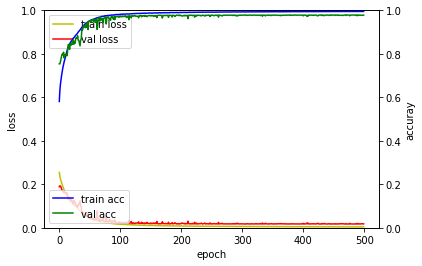

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 확인

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]
    print('mask_.shape', mask_.shape)

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    print(mask_[0][:,:])
    plt.imshow(mask_[0][:,:], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:], 'gray')   # x, y shape가 달랐던 부분 맞춰줌
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')  
    # matplot에서는 흑백이면 shape가 2차원, 컬러면 3차원으로 표현해야함 ([:,:,0]으로 표현하는 이유)
    # 위 코드는 원래 컬러 이미지로 표현되지만 'gray'톤을 적용해서 흑백처럼 보이는것

    plt.show()

    print(preds_test_t.shape)

mask_.shape (1, 256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 23ms/step - loss: 0.0034 - accuracy: 0.9959


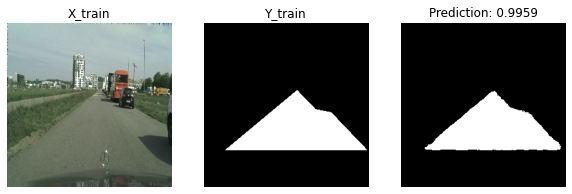

1/1 [==============================] - 0s 29ms/step - loss: 0.0140 - accuracy: 0.9829


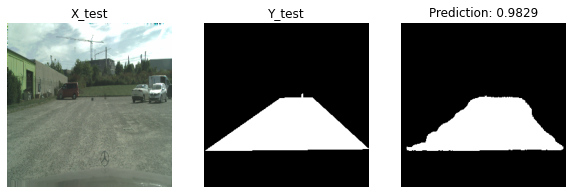

(1, 256, 256, 1)


In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)

학습량을 500으로 늘려주고 나니 학습이 매우 잘되는것으로 보임

테스트데이터로 예측그림을 그려봐도 잘 나옴